In [1]:
import os
from joblib import Parallel, delayed

import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from tqdm import tqdm

from src.CPQAOA import CP_QAOA
from src.QAOA import QAOA
from src.Grid import Grid
from src.Chain import Chain
from src.Tools import (portfolio_metrics, 
                       min_cost_partition, 
                       get_qubo, 
                       normalized_cost, 
                       qubo_limits, 
                       check_qubo,
                       qubo_cost,
                       partitioned_averages)

In [2]:
# Number of Qubits 
N=8
# Number of excitations
k=4
# RNG seed for reproducibility
seed=0
# alpha in: s^T*mu + alpha*(s^T*Covar*s)
alpha=0.5
# Nr. of layer repetitions
layers=1
# Maximal number of iterations for classical solver
max_iter=400
# Using next nearest neighbors (in 1D chain model)
w_next_nearest_neighbors = True


my_chain = Chain(N_qubits=N)
print(f' Qubit indices in chain: \n', my_chain.get_chain_indexing())
print(f'\n Corresponding Nearest Neighbor index pairs: \n', my_chain.get_NN_indices())
print(f'\n Corresponding Nearest Neighbor + Next Nearest index pairs: \n', my_chain.get_NNN_indices())
init_strat = np.array([0,1,0,1,0,1,0,1])
my_chain.set_initialization_strategy(strategy=init_strat)
print(f'\n Initialization strategy is: \n', my_chain.get_initialization_strategy())
print(f'\n Corresponding indices is: \n', my_chain.get_initialization_indices())

 Qubit indices in chain: 
 [0 1 2 3 4 5 6 7]

 Corresponding Nearest Neighbor index pairs: 
 [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7)]

 Corresponding Nearest Neighbor + Next Nearest index pairs: 
 [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (2, 4), (3, 4), (3, 5), (4, 5), (4, 6), (5, 6), (5, 7)]

 Initialization strategy is: 
 [0 1 0 1 0 1 0 1]

 Corresponding indices is: 
 [1, 3, 5, 7]


In [3]:
# Deciding between grid and 1d chain topology
my_topology = my_chain

In [4]:
# Generating random problem instance 
expected_returns, covariances = portfolio_metrics(n=N, seed=seed)

# Retrieving C_min, C_max and corresponding states for original portfolio problem
constrained_result, full_result, lmbda = min_cost_partition(nr_qubits=N,
                                                            k=k,
                                                            mu=expected_returns,
                                                            sigma=covariances,
                                                            alpha=alpha)

portfolio_subspace_max_cost, portfolio_subspace_min_cost, portfolio_subspace_min_state = constrained_result['c_max'], constrained_result['c_min'], constrained_result['s']
full_space_max_cost = full_result['c_max']
portfolio_subspace_min_state_str = ''.join([str(_) for _ in portfolio_subspace_min_state])
print(f"Min. cost portfolio (constrained subspace): {portfolio_subspace_min_cost}")
print("Optimal portfolio state (constrained subspace) is: |"+portfolio_subspace_min_state_str+">")

Min. cost portfolio (constrained subspace): 8.554358959067997
Optimal portfolio state (constrained subspace) is: |00101110>


In [5]:

# Generating QUBO corresponding to current problem instance
Q, offset = get_qubo(mu=expected_returns,
                     sigma=covariances, 
                     alpha=alpha,
                     lmbda=lmbda+1e-8, # Adding small constant purposely
                     k=k)
QUBO_limits = qubo_limits(Q=Q,offset=offset)
qubo_min_cost, qubo_max_cost = QUBO_limits['c_min'], QUBO_limits['c_max']
qubo_min_state, qubo_max_state = QUBO_limits['min_state'], QUBO_limits['max_state']
check_qubo(QUBO_matrix=Q, QUBO_offset=offset, expected_returns=expected_returns, covariances=covariances, alpha=alpha, k=k)
qubo_min_state_str = ''.join([str(_) for _ in qubo_min_state])
print(f"Min. cost QUBO: {qubo_min_cost}")
print("Min. cost QUBO state is: |"+qubo_min_state_str+">")


Min. cost QUBO: 8.554358959067997
Min. cost QUBO state is: |00101110>


In [6]:
print("Check that qubo min cost is same as portfolio min cost:")
qubo_min_cost, portfolio_subspace_min_cost

Check that qubo min cost is same as portfolio min cost:


(8.554358959067997, 8.554358959067997)

In [7]:
print("Check that qubo max cost is at least portfolio max cost:")
qubo_max_cost, portfolio_subspace_max_cost

Check that qubo max cost is at least portfolio max cost:


(193.01434665762594, 18.8257571076687)

In [8]:
# Generating instances of ansatz'
CP_z_phase_ansatz = CP_QAOA(N_qubits=N,
                 cardinality=k,
                 layers=layers,
                 topology=my_topology,
                 QUBO_matrix=Q,
                 with_next_nearest_neighbors=w_next_nearest_neighbors,
                with_gradient=True,
                 with_z_phase=False)

In [32]:
# Choosing optimizer for scipy
available_methods = ['COBYLA', 'Nelder-Mead', 'BFGS']
optimizer_method = available_methods[2]

# Designing own convergence tol
#convergence_eps = 0.0005

# Generating callback function for plotting
CP_z_phase_costs = [] # Normalized costs
CP_z_phase_probs = [] # probability of optimal state
CP_z_phase_most_probables = []
solver_costs=[]

def CP_z_phase_callback_function(x):
    _dict_ = CP_z_phase_ansatz.get_state_probabilities(flip_states=False)
    CP_z_phase_most_probables.append(list(_dict_.keys())[np.argmax(list(_dict_.values()))])
    # N.B. Normalizing w. respect to full space max cost
    _cost_ = normalized_cost(result=_dict_,
                             QUBO_matrix=Q,
                             QUBO_offset=offset,
                             max_cost=portfolio_subspace_max_cost, 
                             min_cost=qubo_min_cost)
    if portfolio_subspace_min_state_str in list(_dict_.keys()):
        CP_z_phase_probs.append(_dict_[portfolio_subspace_min_state_str])
    else:
        CP_z_phase_probs.append(0)
    CP_z_phase_costs.append(_cost_)
    
    """new_solver_cost = CP_z_phase_ansatz.get_cost(x)
    if len(solver_costs) > 300:
        solver_costs.append(new_solver_cost)
        if np.std(solver_costs[-300:]) < convergence_eps:
            raise Exception("Termination criteria met")
    else:
        solver_costs.append(new_solver_cost)"""

# Generating initial guess for rotation angles for CP_ansatz
np.random.seed(seed)
theta_min, theta_max = -2*np.pi, 2*np.pi
N_angles = layers * len(my_topology.get_NN_indices())
if w_next_nearest_neighbors:
    N_angles += layers * len(my_topology.get_NNN_indices())
#N_angles += layers * N # Because this is WITH Z-phase
CP_z_phase_theta_i = np.random.uniform(low=theta_min, high=theta_max, size=N_angles)
print(f"CP+Z-PHASE: {len(CP_z_phase_theta_i)}")

# Saving initial cost
# solver_costs.append(CP_z_phase_ansatz.get_cost(CP_z_phase_theta_i))
#try:
    # Performing optimization
    

CP+Z-PHASE: 19


In [33]:
cost = CP_z_phase_ansatz.get_cost(CP_z_phase_theta_i)
cost

-1.7435651928862104

In [34]:
grad = CP_z_phase_ansatz.get_gradient(CP_z_phase_theta_i)

In [35]:
grad

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  6.24064210e-01,
       -1.14410758e-01,  1.97883310e-01, -9.08996780e-01, -5.84838329e-18,
        5.76465639e-18,  8.93163658e-02, -1.89937324e+00,  8.57933008e-03,
        4.43613168e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -7.32507843e+00,  4.62298483e-01,  3.95629623e-01])

In [40]:
    
CP_z_phase_res = sc.optimize.minimize(fun=CP_z_phase_ansatz.get_cost, 
                                      x0=CP_z_phase_theta_i,
                                      method='Newton-CG',
                                      options={'disp': False, 
                                               'maxiter': max_iter},
                                      jac=CP_z_phase_ansatz.get_gradient,
                                      callback=CP_z_phase_callback_function)
"""except Exception as e:
    if str(e) == "Termination criteria met":
        print("Optimization stopped due to custom termination criteria.")"""

C:\Users\madse\AppData\Local\Temp\ipykernel_9700\1432900080.py:1: OptimizeWarning: Unknown solver options: gtol
  CP_z_phase_res = sc.optimize.minimize(fun=CP_z_phase_ansatz.get_cost,


KeyboardInterrupt: 

In [37]:
CP_z_phase_res

 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: -1.7825082848354479
       x: [ 6.134e-01  2.704e+00 ...  3.845e+00  3.226e+00]
     nit: 3
     jac: [ 0.000e+00  0.000e+00 ...  4.839e-01  3.261e-01]
    nfev: 97
    njev: 86

In [38]:
np.linalg.norm(CP_z_phase_res.jac)

4.161780096342679

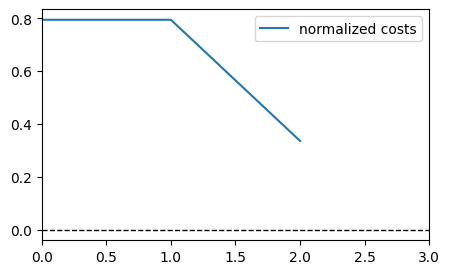

In [39]:
# N.B. Because the normalization is done w. respect to the "allowed states (w. k ones)" QAOA has cost above 1.
fig, ax = plt.subplots(1,1, figsize=(5,3))
ax.plot([it for it in range(len(CP_z_phase_costs))], CP_z_phase_costs, label='normalized costs')
ax.set_xlim(0,len(CP_z_phase_costs))
ax.hlines(0,0,len(CP_z_phase_costs),lw=1,linestyles='dashed',colors='k')
ax.legend(loc='upper right')
plt.show()

In [458]:
opt_state = CP_z_phase_most_probables[np.argmin(solver_costs)]
opt_state, ''.join(str(q) for q in portfolio_subspace_min_state_str)

('1010101001', '1010101001')

In [459]:
found_cost = qubo_cost(np.array([float(_) for _ in opt_state]).astype(np.float64), Q) + offset
abs(found_cost - portfolio_subspace_min_cost) / abs(portfolio_subspace_max_cost - portfolio_subspace_min_cost)

4.313062108042641e-15

In [437]:
max_iter = 10000

sizes = [2,3,
         4,5,
         6,7,
         8,9,
         10]

cardinalities = [1,1,
                 2,2,
                 3,3,
                 4,4,
                 5]

layers = [1,1,1,
          2,2,2,
          3,3,3]

initialization_strategies = [np.array([0,1]),
                             np.array([0,1,0]),
                             np.array([0,1,0,1]),
                             np.array([0,1,0,1,0]),
                             np.array([0,1,0,1,0,1]),
                             np.array([0,1,0,1,0,1,0]),
                             np.array([0,1,0,1,0,1,0,1]),
                             np.array([0,1,0,1,0,1,0,1,0]),
                             np.array([0,1,0,1,0,1,0,1,0,1])]



In [33]:
from qiskit import QuantumCircuit, Aer, execute
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import Operator
from qiskit.quantum_info.operators import Pauli
from qiskit.opflow import X, Y, I



In [45]:
def get_generator(i:int, j:int, theta: float, N: int) -> np.ndarray:
    if i == 0 or j == 0:
        res_x, res_y = 'X', 'Y'
        for qubit_idx in range(1,N):
            if j == qubit_idx or i == qubit_idx:
                res_x += 'X'
                res_y += 'Y'
            else:
                res_x += 'I'
                res_y += 'I'
    else:
        res_x, res_y = 'I', 'I'
        for qubit_idx in range(1,N):
            if j == qubit_idx or i == qubit_idx:
                res_x += 'X'
                res_y += 'Y'
            else:
                res_x += 'I'
                res_y += 'I'
    return theta * (np.array(Operator(Pauli(res_x)))+np.array(Operator(Pauli(res_y))))

In [46]:
get_generator(1,3,0,4).shape

(16, 16)

In [35]:
h = Pauli('IIXXIY')
Operator(h)

Operator([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
          ...,
          [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],
         input_dims=(2, 2, 2, 2, 2, 2), output_dims=(2, 2, 2, 2, 2, 2))


In [ ]:
N=4
qubit_i, qubit_j = 1,0
op = 

In [29]:
qcircuit = QuantumCircuit(2)
theta_ij = 0.1651
qubit_i, qubit_j = 0, 1
# Define the Hamiltonian for XX and YY interactions
xx_term = theta_ij * (X ^ X)
yy_term = theta_ij * (Y ^ Y)
hamiltonian = xx_term + yy_term

# Create the time-evolved operator
time_evolved_operator = PauliEvolutionGate(hamiltonian, time=1.0)

qcircuit.append(hamiltonian, [qubit_i, qubit_j])

ValueError: Input matrix is not unitary.

In [30]:
np.array(Operator(hamiltonian)).shape

(4, 4)